In [ ]:
import tensorflow as tf
import numpy as np
import math
import random
from tensorflow.keras import Model, Input, layers, optimizers, utils, callbacks
import matplotlib.pyplot as plt
import datetime
from PIL import Image, ImageDraw
#tf.compat.v1.disable_eager_execution()
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class Beamscanner:
    def __init__(self, num_data, slm_info, num_z_planes, z_sep, focal_length, wavelength):
        # Inputs
        # num_data:        Number of sets to train the newwork on
        # slm_info:        Tuple (int, int, float, float, float) containing 
        #                  (slm resolution x, slm resolution y, slm pixel pitch)
        # num_z_planes:    Number of separated planes around the focal plane. MUST BE UNEVEN.
        # z_sep:           Distance between separated planes.
        # focal_length:    Focal length, or, the distance to the center plane.
        # wavelength:      wavelength used in the system [nm].
        
        
        self.nT = num_data
        self.nV = int(num_data * 0.25)
        self.Mx = slm_info[0]
        self.My = slm_info[1]
        self.lp = slm_info[2]
        self.l0x = self.Mx * self.lp
        self.l0y = self.My * self.lp
        self.nz = num_z_planes
        self.dz = z_sep
        self.f = focal_length
        self.wl = wavelength*10**-9
        self.batch_size = 32
        self.IF = 8
        
        self.epochs = 3
        
        self._calculate_phase_factors()
    
    def set_batch_size(self, batch_size):
        self.batch_size = batch_size
        
    def set_epochs(self, epochs):
        self.epochs = epochs
    
    def get_sample(self):
        return self.training_data[0:31]
        
    def print_model_summary(self):
        self.model.summary()

# TRAINING AND VALIDATION DATA


    def _create_lines(self, N_images):
      line_images = np.zeros((N_images, self.Mx, self.My, self.nz))
      for image in line_images:
        for plane in range(self.nz):
          im = Image.fromarray(image[:, :, plane])
          draw_im = ImageDraw.Draw(im)
          num_lines = random.randint(0, 10)
          for n_line in range(num_lines):
            start_x = random.randint(10, self.Mx-10)
            start_y = random.randint(10, self.My-10)
            stop_x = random.randint(10, self.Mx-10)
            stop_y = random.randint(10, self.My-10)
            draw_im.line((start_x, start_y, stop_x, stop_y), fill=random.randint(128, 256), width=random.randint(1, 3))
          image[:,:,plane] = np.array(im)
        
      return line_images
    
    def _create_circles(self, N_images):
      circle_images = np.zeros((N_images, self.Mx, self.My, self.nz))
      for image in circle_images:
        for plane in range(self.nz):
          im = Image.fromarray(image[:, :, plane])
          draw_im = ImageDraw.Draw(im)
          num_circles = random.randint(0, 10)
          for n_circle in range(num_circles):
            diameter = random.randint(2, int(self.Mx / 4))
            x_0 = random.randint(diameter, self.Mx-diameter)
            y_0 = random.randint(diameter, self.My-diameter)
            x_1 = x_0 + diameter
            y_1 = y_0 + diameter
            draw_im.ellipse([(x_0, y_0), (x_1, y_1)], outline = random.randint(0, 256), fill=random.randint(0, 256), width=random.randint(1, 3))
          image[:,:,plane] = np.array(im)
        
      return circle_images
    
    def _create_polygons(self, N_images):
      poly_images = np.zeros((N_images, self.Mx, self.My, self.nz))
      for image in poly_images:
        for plane in range(self.nz):
          im = Image.fromarray(image[:, :, plane])
          draw_im = ImageDraw.Draw(im)
          num_polys = random.randint(0, 10)
          for n_poly in range(num_polys):
            radius = random.randint(10, int(self.Mx / 4))
            x_0 = random.randint(radius, self.Mx-radius)
            y_0 = random.randint(radius, self.My-radius)
            n_sides = random.randint(3, 6)
            xs = [random.randint(x_0-radius, x_0 + radius) for n in range(n_sides)]
            ys = [random.randint(y_0-radius, y_0 + radius) for n in range(n_sides)]
            xy = [val for pair in zip(xs, ys) for val in pair]
            draw_im.polygon(xy, outline = random.randint(0, 256), fill=random.randint(0, 256))
          image[:,:,plane] = np.array(im)
        
      return poly_images

    
    def _generate_training_data(self):
        print("Generating training data...")
        #training_planes = np.zeros((self.nT, self.Mx, self.My, self.nz))
        #for i in range(self.nT):
        #    plane_with_spot = random.randint(0, self.nz - 1)
        #    spot_x = self.Mx//2  #random.randint(10, self.Mx-10)
        #    spot_y = self.My//2 #random.randint(10, self.My-10)
        #    spot_radius = random.randint(1, 4)
        #    training_planes[i, spot_x-spot_radius:spot_x+spot_radius, spot_y-spot_radius:spot_y+spot_radius, plane_with_spot] = 1
        self.training_data = self._create_lines(self.nT)
            
    
    def _generate_validation_data(self):
        print("Generating validation data...")
        #validation_planes = np.zeros((self.nV, self.Mx, self.My, self.nz))
        #for i in range(self.nV):
        #    plane_with_spot = random.randint(0, self.nz - 1)
        #    spot_x = self.Mx//2 #random.randint(10, self.Mx-10)
        #    spot_y = self.My//2 # random.randint(10, self.My-10)
        #    spot_radius = random.randint(1, 4)
        #    validation_planes[i, spot_x-spot_radius:spot_x+spot_radius, spot_y-spot_radius:spot_y+spot_radius, plane_with_spot] = 1
        self.validation_data = self._create_lines(self.nV)

# FOURIER OPTICS SPECIFIC FUNCTIONS
    def _calculate_phase_factors(self):
        fx = np.linspace(-self.Mx / 2 + 1, self.Mx / 2, self.Mx) * 1 / (self.lp * self.Mx)
        fy = np.linspace(-self.My / 2 + 1, self.My / 2, self.My) * 1 / (self.lp * self.My)
        Fx, Fy = np.meshgrid(fx, fy)
        
        center = self.nz // 2
        phase_factors = []

        for n in range(self.nz):
            zn = n - center
            p = np.exp(-1j * math.pi * self.wl * (zn * self.dz) * (Fx ** 2 + Fy ** 2))
            phase_factors.append(p.astype(np.complex64))
        self.phase_factors = phase_factors

    def _prop_to_slm(self, inputs):
        # We need to propagate the input backwards to the SLM with ifft2
        real, imag = inputs
        field_z0 = tf.complex(tf.squeeze(real), 0.) * tf.exp(tf.complex(0., tf.squeeze(imag)))   
        shift = tf.signal.fftshift(field_z0, axes=[1,2])
        slm = tf.math.angle(tf.signal.ifftshift(tf.signal.ifft2d(shift)))
        return tf.expand_dims(slm, axis=-1)

    def _prop_to_planes(self, slm_phase):
        # Then propagate to the z planes we have defined
        phi_slm = tf.complex(np.float32(0.), tf.squeeze(slm_phase))
        phi_slm = tf.math.exp(phi_slm)

        output_list = []
        for factor in self.phase_factors:
            phased_slm_layer = tf.multiply(phi_slm, factor)
            fft = tf.signal.fftshift(tf.signal.fft2d(phased_slm_layer))
            I = tf.cast(tf.math.square(tf.math.abs(fft)), tf.float32)
            output_list.append(tf.squeeze(I))
        return tf.stack(output_list, axis=3)

 # LAYERS   

    def _cc_layer(self, n_feature_maps, input):
      x = layers.Conv2D(n_feature_maps, (3, 3), activation='relu', padding='same')(input)
      x = layers.Conv2D(n_feature_maps, (3, 3), activation='relu', padding='same')(x)
      return x
    
    def _cbn_layer(self, n_feature_maps, input):
      x = layers.Conv2D(n_feature_maps, (3, 3), activation='relu', padding='same')(input)
      x = layers.BatchNormalization()(x)
      x = layers.Conv2D(n_feature_maps, (3, 3), activation='relu', padding='same')(x)
      x = layers.BatchNormalization()(x)
      return x

    def _interleave(self, input):
        return tf.nn.space_to_depth(input = input, block_size = self.IF)

    def _deinterleave(self, input):
      return tf.nn.depth_to_space(input = input, block_size = self.IF)

    def _shallow_Unet(self, input_layer):
        x1 = self._cbn_layer(64, input_layer)
        x = layers.MaxPooling2D((2, 2))(x1)
        x2 = self._cbn_layer(128, x)
        x = layers.MaxPooling2D((2, 2))(x2)
        x = self._cc_layer(256, x)
        x = layers.UpSampling2D()(x)
        concat2 = layers.Concatenate()([x2, x])  
        x = self._cc_layer(128, concat2)
        x = layers.UpSampling2D()(x)
        concat1 = layers.Concatenate()([x1, x])  
        x = self._cc_layer(64, concat1)
        
        return x
    
    def _branching(self, previous, before_unet):
        real_branch = self._cc_layer(64, previous)
        real_branch = layers.concatenate([real_branch, before_unet])
        real_branch = self._cc_layer(self.IF**2, real_branch)
        imag_branch = self._cc_layer(64, previous)
        imag_branch = layers.concatenate([imag_branch, before_unet])
        imag_branch = self._cc_layer(self.IF**2, imag_branch)
        de_int_real = layers.Lambda(self._deinterleave, name="De-interleave_real")(real_branch)
        de_int_imag = layers.Lambda(self._deinterleave, name="De-interleave_imag")(imag_branch)
        
        slm_phase = layers.Lambda(self._prop_to_slm, name="SLM_phase")([de_int_real, de_int_imag])
        
        return slm_phase
    
    def _prop_layer(self, previous):
        return layers.Lambda(self.prop_to_planes, name="z-planes")(previous)
    
# ABSTRACTIONS

    def _loss_func(self, y_true, y_pred):
        
        y_predict = self._prop_to_planes(y_pred)
        
        num = tf.reduce_sum(y_predict * y_true, axis=[1, 2, 3])
        denom = tf.sqrt(tf.reduce_sum(tf.pow(y_predict, 2), axis=[1, 2, 3])*tf.reduce_sum(tf.pow(y_true, 2), axis=[1, 2, 3]))
        return 1 - tf.reduce_mean((num + 1) / (denom + 1), axis=0)

    def create_model(self):
        train_in = Input((self.Mx, self.My, self.nz,), name='Input', batch_size=self.batch_size)
        interleaved = layers.Lambda(self._interleave, name='Interleave')(train_in)
        unet = self._shallow_Unet(interleaved)
        slm_phi = self._branching(unet, interleaved)
        self.model = Model(train_in, slm_phi)
        self.model.compile(optimizer=optimizers.Adam(), loss=self._loss_func, metrics=['acc'])
    
    def train(self):
      savefile = "/content/drive/MyDrive/Speciale/Private/ML/Beamscanner-ml-jupyter/nz{}-M{}x{}-b{}-e{}-{}".format(self.nz, self.Mx, self.My, self.batch_size, self.epochs, datetime.datetime.now())
      savefile = savefile + "-unet_2level_w_concat" + ".csv"
      csv_logger = callbacks.CSVLogger(savefile, append=True)
      self.model.fit(self.training_data, self.training_data, epochs=self.epochs, batch_size=self.batch_size, validation_data=(self.validation_data, self.validation_data), callbacks=[csv_logger])
        
    def predict(self, planes):
        phi_slm = self.model.predict(planes)
        _z_planes = self._prop_to_planes(phi_slm)
        
        z_planes = _z_planes.numpy()
        
        print("Creating subplots")
        p = np.array(planes)
        
        fig, axs = plt.subplots(2, 4, figsize=(16, 8))
        
        axs[0,1].imshow(p[0, :, :, 0], cmap='gray', interpolation='none')
        axs[0,1].set_title('Desired z=-dz')

        axs[0,2].imshow(p[0, :, :, 1], cmap='gray', interpolation='none')
        axs[0,2].set_title('Desired z=0')

        axs[0,3].imshow(p[0, :, :, 2], cmap='gray', interpolation='none')
        axs[0,3].set_title('Desired z=dz')
        
        axs[1,0].imshow(phi_slm[0, :, :, 0], cmap='gray', interpolation='none')
        axs[1,0].set_title('Generated phase pattern')
        
        axs[1,1].imshow(z_planes[0, :, :, 0], cmap='gray', interpolation='none')
        axs[1,1].set_title('Predicted z=-dz')

        axs[1,2].imshow(z_planes[0, :, :, 1], cmap='gray', interpolation='none')
        axs[1,2].set_title('Predicted z=0')

        axs[1,3].imshow(z_planes[0, :, :, 2], cmap='gray', interpolation='none')
        axs[1,3].set_title('Predicted z=dz')
        
        plt.show()
        

Generating training data...
Generating validation data...
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(32, 256, 256, 3)]  0                                            
__________________________________________________________________________________________________
Interleave (Lambda)             (32, 32, 32, 192)    0           Input[0][0]                      
__________________________________________________________________________________________________
conv2d (Conv2D)                 (32, 32, 32, 64)     110656      Interleave[0][0]                 
__________________________________________________________________________________________________
batch_normalization (BatchNorma (32, 32, 32, 64)     256         conv2d[0][0]                     
_____________________________

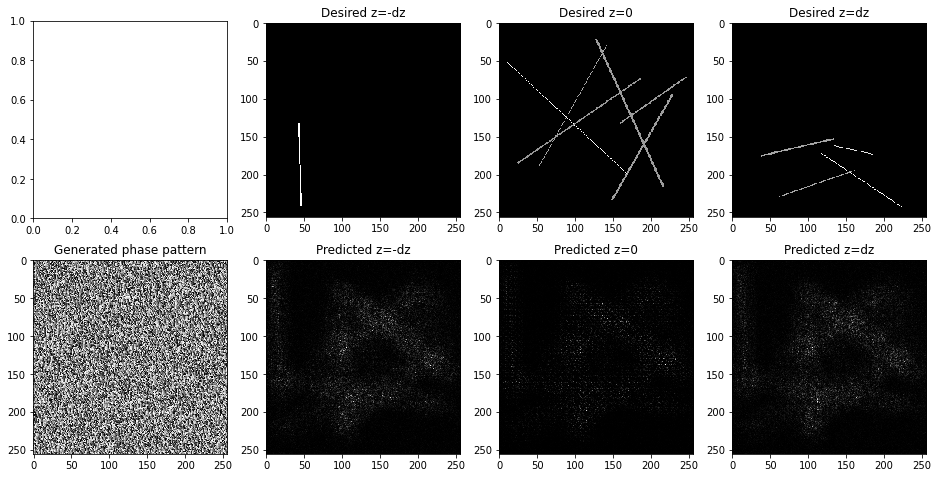

In [ ]:
beamscanner = Beamscanner(2048, (256, 256, 3.90625*10**-5), 3, 0.02, 0.5, 532)

beamscanner.set_batch_size(32)
beamscanner.set_epochs(20)

beamscanner._generate_training_data()
beamscanner._generate_validation_data()

beamscanner.create_model()

beamscanner.print_model_summary()

gt = beamscanner.get_sample()

beamscanner.predict(gt)

beamscanner.train()

beamscanner.predict(gt)
